
## Group No 48

## Group Member Names:
1. Vengadesh S
2. Nipun Gupta
3. Aiswarya S

Our aim is 
1. to develop a model to predict the new credit card transaction is fraud or not with some features of the transaction known.
2. to answer the following Business Questions at the same time:
  - what is the fraud proportion?
  - which state has the highest fraud rate?
  - what are the top 3 fraud categories?

The following sections will be:

-  Import data
-  Data Understsanding
-  Data Preparation
-  Data Modelling - Prediction by Deep Neural Network VS Random Forest
-  Implementation and/or Presentation

# Section 2 : Import Data

## Import data of credit card fraud
The credit card transaction records are fake data from Kaggle: https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv. 

Each row of transaction record includes a lot of features of the transaction inforamtion and label 'is_fraud'.

In [1]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import opendatasets as od
import os

import warnings
warnings.filterwarnings('ignore')
dataset = r"https://www.kaggle.com/kartik2112/fraud-detection"
od.download(dataset)
data_dir = r'.\fraud-detection'
os.listdir(data_dir)

Skipping, found downloaded files in ".\fraud-detection" (use force=True to force download)


['fraudTest.csv', 'fraudTrain.csv']

In [2]:
### two data sources: train and test, combine them together firstly and split them randomly when modelling
### import train data from csv
df_tr = pd.read_csv(r"C:\Users\Venkat\fraud-detection\fraudTrain.csv", index_col=0)
df_tr = df_tr.iloc[:,1:] # the first row is just row order

### import test data
df_test = pd.read_csv(r"C:\Users\Venkat\fraud-detection\fraudTest.csv", index_col=0)
df_test = df_test.iloc[:,1:]

### combine the train dataset and test dataset
df = pd.concat([df_tr,df_test],axis = 0)

# Section 3: Data Understanding

## 3.1 - Exploration of the features and label
###  data overview

In [3]:
### Data overview
print(df.info(null_counts= True)) # all of the features information; 
print(df.nunique()) # all of unique values of different features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 21 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1852394 non-null  int64  
 1   merchant    1852394 non-null  object 
 2   category    1852394 non-null  object 
 3   amt         1852394 non-null  float64
 4   first       1852394 non-null  object 
 5   last        1852394 non-null  object 
 6   gender      1852394 non-null  object 
 7   street      1852394 non-null  object 
 8   city        1852394 non-null  object 
 9   state       1852394 non-null  object 
 10  zip         1852394 non-null  int64  
 11  lat         1852394 non-null  float64
 12  long        1852394 non-null  float64
 13  city_pop    1852394 non-null  int64  
 14  job         1852394 non-null  object 
 15  dob         1852394 non-null  object 
 16  trans_num   1852394 non-null  object 
 17  unix_time   1852394 non-null  int64  
 18  merch_lat   1852394 non

In [4]:
### Data Overview
print(df.describe().transpose()) # the numerical feature statistical summary; 

                count          mean           std           min           25%  \
cc_num      1852394.0  4.173860e+17  1.309115e+18  6.041621e+10  1.800429e+14   
amt         1852394.0  7.006357e+01  1.592540e+02  1.000000e+00  9.640000e+00   
zip         1852394.0  4.881326e+04  2.688185e+04  1.257000e+03  2.623700e+04   
lat         1852394.0  3.853931e+01  5.071470e+00  2.002710e+01  3.466890e+01   
long        1852394.0 -9.022783e+01  1.374789e+01 -1.656723e+02 -9.679800e+01   
city_pop    1852394.0  8.864367e+04  3.014876e+05  2.300000e+01  7.410000e+02   
unix_time   1852394.0  1.358674e+09  1.819508e+07  1.325376e+09  1.343017e+09   
merch_lat   1852394.0  3.853898e+01  5.105604e+00  1.902742e+01  3.474012e+01   
merch_long  1852394.0 -9.022794e+01  1.375969e+01 -1.666716e+02 -9.689944e+01   
is_fraud    1852394.0  5.210015e-03  7.199217e-02  0.000000e+00  0.000000e+00   

                     50%           75%           max  
cc_num      3.521417e+15  4.642255e+15  4.992346e+18 

### Correlation of all the data 
- there is much more no fraud records than fraud records
- 'amt' is the largest correlated feature with data labelm

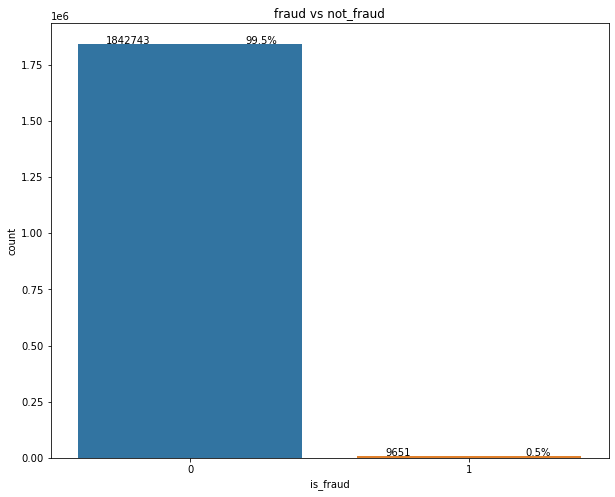

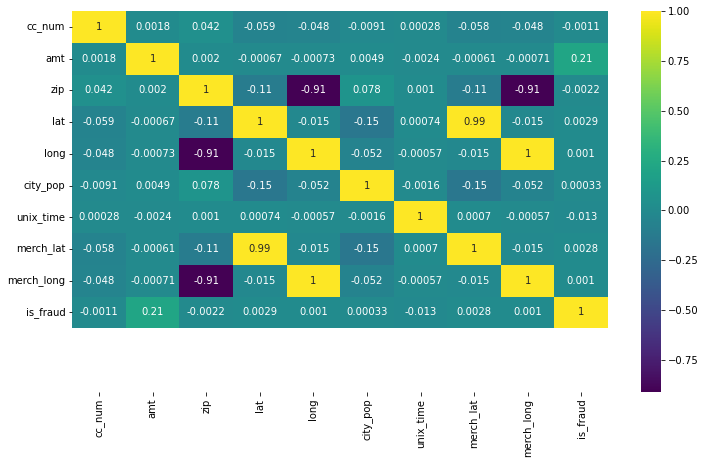

In [5]:
### Exploration of the features and label
plt.figure(figsize = (10,8))
ax = sns.countplot(x ='is_fraud',data = df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()-0.9))
    ax.annotate('{}%'.format(round((100*p.get_height())/df.shape[0],1)), (p.get_x()+0.6, p.get_height()+0.2))   
plt.title('fraud vs not_fraud')
plt.show()

### visualization of the correlation
plt.figure(figsize = (12,7))
sns.heatmap(df.corr(),annot = True, cmap = 'viridis')
plt.ylim(12, 0)
plt.show()

### Different fraud percentage in different groups
- 100% transcation in state DE is fraud
- top 3 high percentage fraud categories are shopping net, misc_net, grocery_pos
- more female transaction records than male in the data

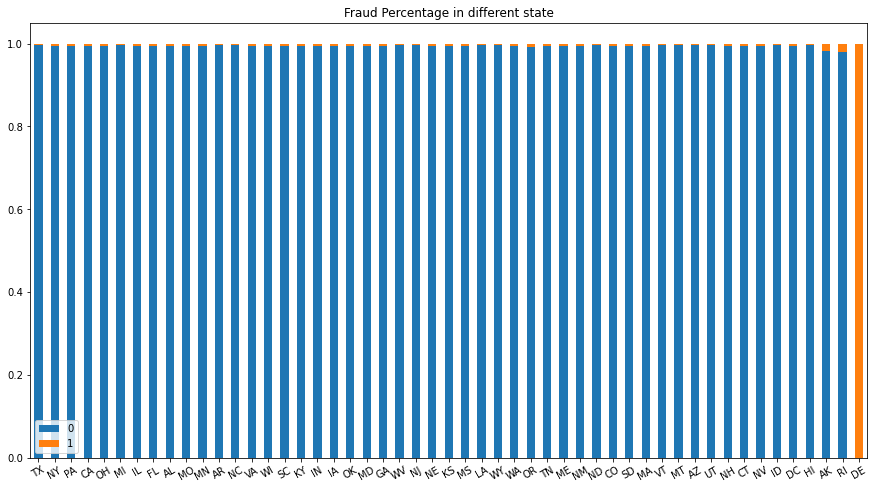

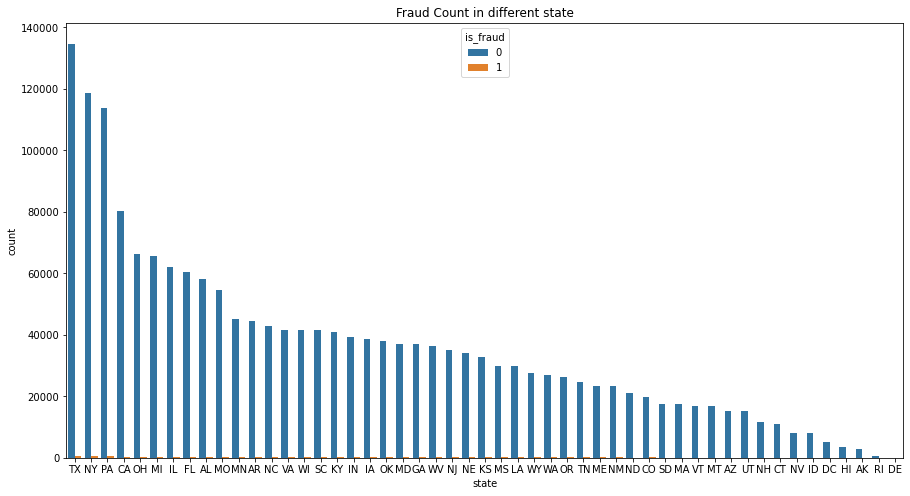

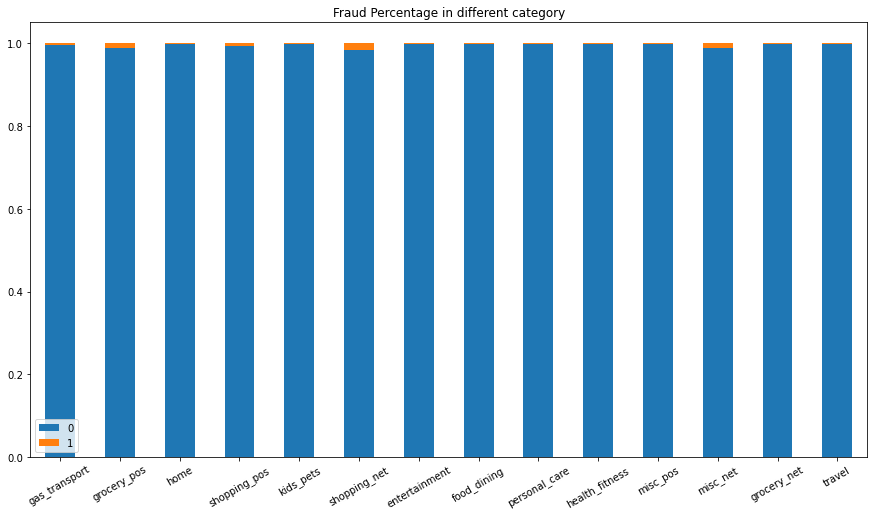

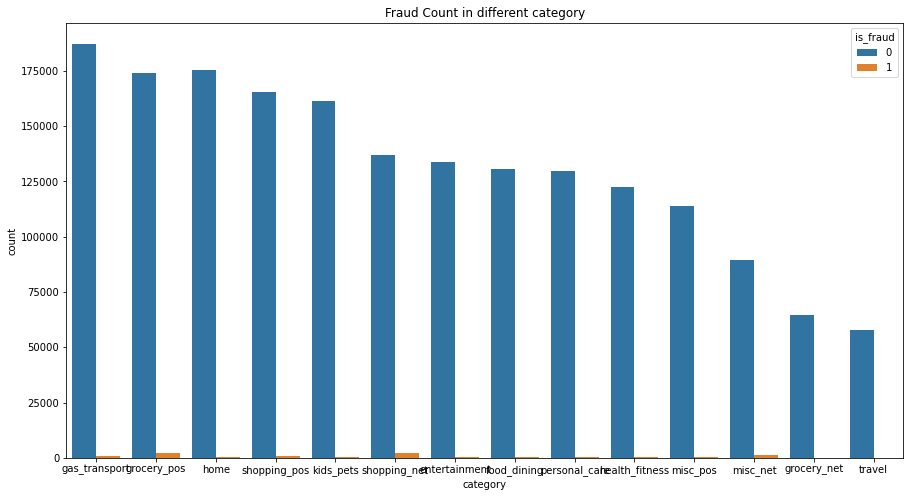

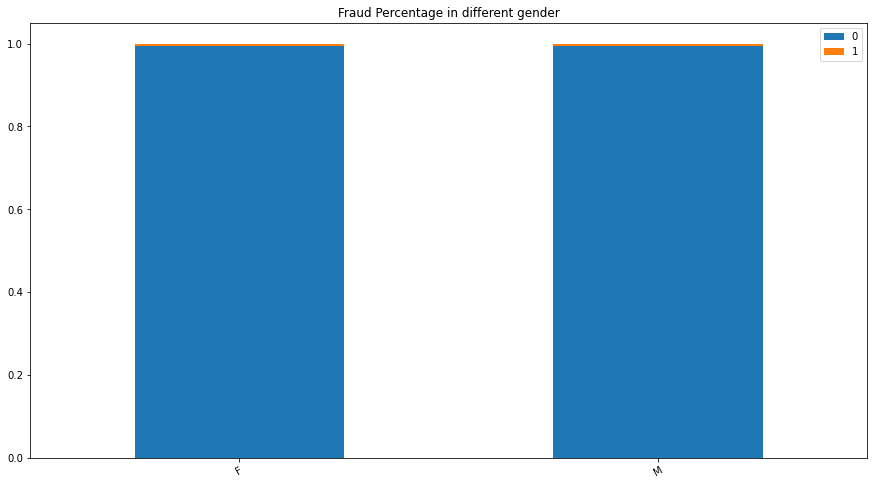

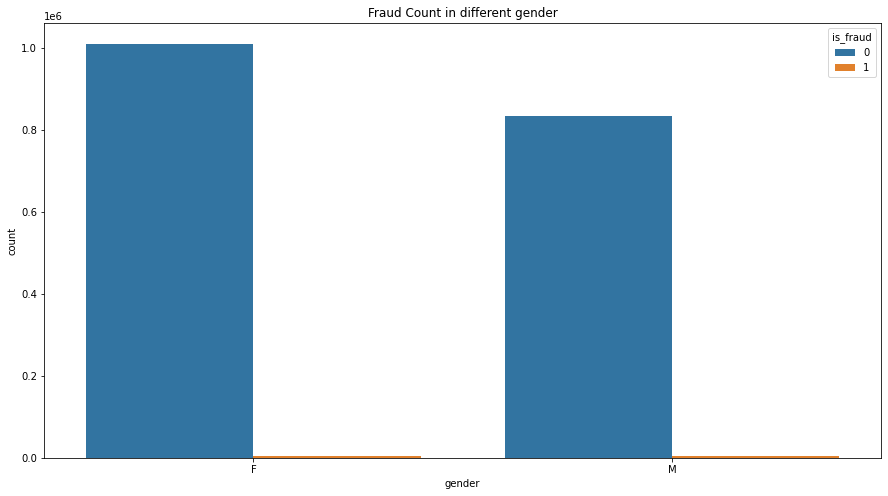

In [6]:
### different feature, fraud percentage:
### the top 3 high percentage is shopping net, misc_net, grocery_pos
def plot_FraudPer_byF(feature):
    feature_per = pd.DataFrame()
    for feature_i in list(df[feature].value_counts().index):
        feature_iper = df[df[feature] == feature_i].groupby('is_fraud').count()['cc_num']/df[df[feature] == feature_i].shape[0]
        feature_iper.rename(feature_i, inplace = True) 
        feature_per = pd.concat([feature_per, feature_iper], axis = 1) 
    feature_per.transpose().plot(kind = 'bar', stacked=True, figsize = (15,8))
    plt.title('Fraud Percentage in different {}'.format(feature))
    plt.xticks(rotation = 30)
    plt.show()
    
### count fraud with different values of one feature
def plot_Fraud_byF(feature):
    plt.figure(figsize=(15,8))
    feature_order = df[feature].value_counts().index
    sns.countplot(x = feature, data = df, order = feature_order, hue = 'is_fraud')
    plt.title('Fraud Count in different {}'.format(feature))
    plt.show()

### examples to plot the fraud count/percentage by features values
feature = 'state'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

feature = 'category'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

feature = 'gender'
plot_FraudPer_byF(feature)
plot_Fraud_byF(feature)

### order by fraud percentage tables
#feature_per.transpose().sort_values(by =1, ascending = False)

## 3.2 Summary
Answers to Qs:  
  - what is the fraud proportion?
  0.5%
  - which state has the highest fraud rate?
  DE
  - what are the top 3 fraud categories?
  Shopping_Net, Grocery_pos, Misc_net 
  

## Section 4: Data Preparation

### 4.1 Feature engineering
- select the likely features 
- reduce the categories of some features, like job
- drop some features like merchant (due to model overfitting with it) 
- transfer the object feature type to dummy variables

In [7]:
### amount shows the highest correlation with data label 'is_fraud'
### drop some features with least possibility like first name, last name and longtitue, latitude
### 693 merchants was included in the first time modelling but overfitting with it, so drop it
df = df[['amt','category','state','gender','job','is_fraud']]

### reduce the unique job counts by the following criteria:
### all jobs with appearance amount <1000, put in 'other'
low_count_job = df.job.value_counts()[df.job.value_counts().values < 1000].index
df.loc[df.job.isin(low_count_job), ['job']] = 'other'

###### transfer 14 category, 2 genders, 51 state and 418 job names to dummy variables
dummies = pd.get_dummies(df[['category', 'gender','state','job']],drop_first=True)
df = df.drop(['category', 'gender','state', 'job'],axis=1)
df = pd.concat([df,dummies],axis = 1)

# Section 5: Data Modelling
## 5.1- split to train and test randomly
- set X and y for feature and lable
- split to train and test
- Normalise the data

In [ ]:
### Modelling
### Set X and y variables to the features and label
X = df.drop('is_fraud', axis =1).values
y = df['is_fraud'].values

from sklearn.model_selection import train_test_split
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42,shuffle=True)
X_train.shape
X_test.shape
y_train.shape
y_test.shape
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5.2 - Neural network model with Keras API
- import libraries
- sequential model with dense layers, drop out, activation function, early stop etc.
- regularizer set zero, since l2 regularizer did not give better result

### Import tensorflow libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

### Sequential models with specific dense layers, drop out, activation functions etc through trial and test.

In [ ]:
model = Sequential()
factor = 0

# input layer
model.add(Dense(500,  kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(250, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(120, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(60, kernel_regularizer=l2(factor), activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(30, kernel_regularizer=l2(factor),activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks= [early_stop]
          )

from tensorflow.keras.models import load_model
model.save('Fraud_Detect_ANN_model_final.h5') 

### plotting losses of train and test data with binary cross entropy as loss functions

In [ ]:
### losses function of train and test data, very low loss and no overfitting
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

### Fraud Detection Neural Network Model Evaluation
- Precision is 0.79, i.e. the ratio of correctly predicted positive (is fraud) to the total predicted positive is 79%.  
- Recall is 0.53, i.e. the ratio of correctly predicted positive (is fraud) to all positive observations is 53%. 
- f1-score is 0.64, is the balance of Precision and Recall. 

- Formulas:
    - Precison = True Positive/(True Positive + False Positive) 
    - Recall = True Positive/(True Positive + False Negative)
    - f1-score =  2*((Precision * Recall)/(Precision + Recall))
- Confusion matrix: 
                     True Positive  False Negative
                     False Positive True Negative

In [ ]:
### Classification report and confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))
print('Confusion matrix is as below:\n')
print(confusion_matrix(y_test,predictions))

## 5.3: Another Model - Random Forest

In [ ]:
### split the data to train and test
from sklearn.model_selection import train_test_split
X = df.drop('is_fraud',axis=1)
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
### call random forest model to fit and predict
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators  = 300)

rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

## 5.5  Summay of the model evaluations
How good the model preforms?
Confusion Matrix:
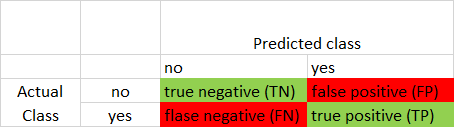

- **Accuracy**: is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total  observations. 
  - Accuracy = (TP+TN)/(TP+FP+FN+TN)

- **Precision**: is the ratio of correctly predicted positive observations to the total predicted positive observations
  - Precision = TP/(TP+FP)
- **Recall (Sensitivity)**: is the ratio of correctly predicted positive observations to all actual positive observations.
  - Recall = TP/(TP+FN)
- **F1-Score**: is the balance between Precision and Recall.(Harmonic mean of Presicion and Recall)
  - F1 Score = 2*(Recall * Precision) / (Recall + Precision)


1. Neural Network
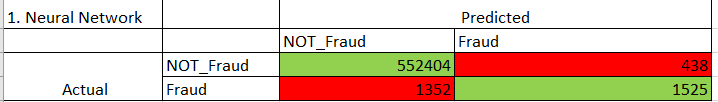
The evaluation of Neural Network model on test data: Accuracy is 99.68%, Precision is 78%, Recall is 53%, F1-score is 63%.

2. Random Forest

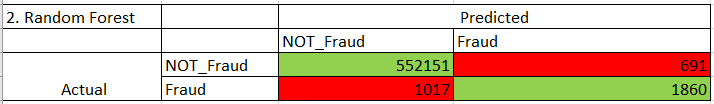

The evaluation of Random Forest model on test data: Accuracy is 99.69%, Precision is 73%, Recall is 65%, F1-score is 69%.

## Section 6 Implementation and/or presentation 

**Recall: our project aim is**
1. to develop a model to predict the new credit card transaction is fraud or not with some features of the transaction known.
2. to answer the following Business Questions at the same time: 
**questions were answered in Section 3 Data Understanding**
  - what is the fraud proportion?
  - which state has the highest fraud rate?
  - what are the top 3 fraud categories?
  
> **We choose Random Forest model to predict credit card transaction is fraud or not, and the prediciton preformance is good with Accuracy 99.69%, Precision 73%, Recall 65%.**

> the correct rate of our prediction is 99.69%, whatever predciting fraud or not_fraud (Accuracy)

> when we predict 100 fraud, 73 is really fraud in actual (Precision)

> when we have 100 actual fraud, we can correctly pick out 65 fraud (Recall)

**Future work:**
- Do we need to improve the preformance of the model?
- How can we improve? (collecting more features?)